*Alonso Evan*

*04/02/2020*

# Rotten Tomatoes Sentiment Analysis

![](http://paxcom.net/wp-content/uploads/2016/09/Words.png)




### Deep Learning / Machine Learning

The dataset is comprised of files with phrases from the Rotten Tomatoes dataset. Each Sentence has been parsed into many phrases by the Stanford parser. Each phrase has a PhraseId. Each sentence has a SentenceId. Phrases that are repeated (such as short/common words) are only included once in the data.

train.tsv contains the phrases and their associated sentiment labels. 

test.tsv contains just phrases. We must assign a sentiment label to each phrase.

The sentiment labels are:

 - 0 - negative

 - 1 - somewhat negative

 - 2 - neutral

 - 3 - somewhat positive

 - 4 - positive
 
For the Deep Learning part, I will use Keras.
Keras is a deep learning framework that actually under the hood uses other deep learning frameworks in order to expose a beautiful, simple to use and fun to work with, high-level API. Keras can use either of these backends:

 - Tensorflow – Google’s deep learning library
 - Theano – may not be further developed
 - CNTK – Microsoft’s deeplearning library
 - MXNet – deeplearning library from Apache.org (currently under development)
 
Keras uses these frameworks to deliver powerful computation while exposing a beautiful and intuitive (that kinda looks like scikit-learn) API.

And for the Machine Learning part I will use all of the classic models (Random Forest, XGBoost, Decision Tree, LightGBM and so on).
 
1. [Import packages](#1)
1. [Load data](#2)
1. [Explore data](#3)
1. [Preprocessing the digit images](#4)
1. [Deep Learning (Neural Network Architecture)](#5)
1. [First Submission to Kaggle](#6)
1. [Machine Learning](#7)
1. [Data Preprocessing](#8)
1. [Model selection](#9)
1. [Second submission to Kaggle](#10)
1. [Deep Learning (part 2)](#11)
1. [Third submission to Kaggle](#12)

<a id="1"></a> <br>
## Import packages

In [3]:
import numpy as np 
import pandas as pd 
import os

import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# The Natural Language Toolkit, or more commonly NLTK, is a suite of libraries and programs for symbolic and 
# statistical natural language processing for English written in the Python programming language.
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from bs4 import BeautifulSoup
import re

#TQDM is a progress bar library with good support for nested loops and Jupyter/IPython notebooks.
from tqdm import tqdm

from keras.utils import to_categorical
import random
import tensorflow
#tensorflow.random.set_seed(x)
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense,Dropout,Embedding,LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)

from wordcloud import WordCloud,STOPWORDS

np.random.seed(4)

Using TensorFlow backend.


<a id="2"></a> <br>
## Load data

In [4]:
train= pd.read_csv("train.tsv", sep="\t")
test = pd.read_csv("test.tsv", sep="\t")

train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [4]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


<a id="3"></a> <br>
## Explore data

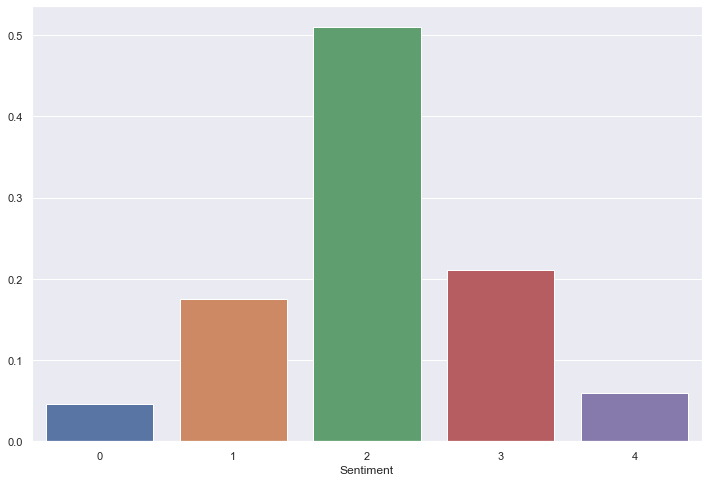

In [39]:
dist = train.groupby(["Sentiment"]).size()
dist = dist / dist.sum()
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(dist.keys(), dist.values);

In [5]:
print("The shape of the train set is :", train.shape)

The shape of the train set is : (156060, 4)


In [6]:
print("The shape of the test set is :", test.shape)

The shape of the test set is : (66292, 3)


Next, we look at the length of all reviews in the Sentence column and measure some statistics.

In [61]:
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)

lens = train['Phrase'].str.len()

print("Mean length (in characters of train reviews :", lens.mean())
print("STD length in characters of train reviews :", lens.std())
print("Min length in characters of train reviews :", lens.min())
print("Max length in characters of train reviews :", lens.max())

Mean length (in characters of train sentences : 40.217224144559786
STD length in characters of train sentences : 38.15412986195699
Min length in characters of train sentences : 1
Max length in characters of train sentences : 283


The average length of the reviews is 40 symbol Also, we have some reviews with more than 280 symbols. It seems, that there are some uniword in our sentences because the shortest sentence is 1 symbols. I guess we maybe need to get rid of it.

Let's also build a histogram with the distribution of the length of our movie reviews. 

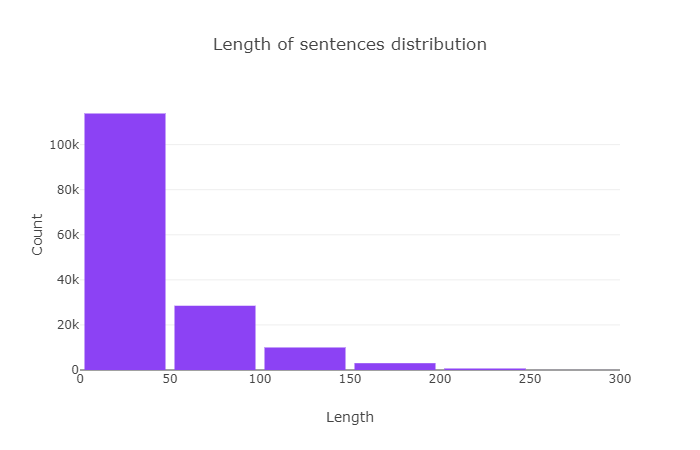

In [65]:
data = [go.Histogram(x=lens, xbins=dict(start=0, end=8000, size=50), marker=dict(color='#8c42f4'))]

layout = go.Layout(title='Length of sentences distribution',xaxis=dict(title='Length'),
                  yaxis=dict(title='Count'),bargap=0.1)



fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='length histogram')

We can see that most of the reviews have a length between 1 and 50 symbols. There are many reviews in the 50-100 symbols range as well. Almost all reviews have a length of fewer than 200 symbols.

We also check if there any correlation between the length of the review and the sentiment label.

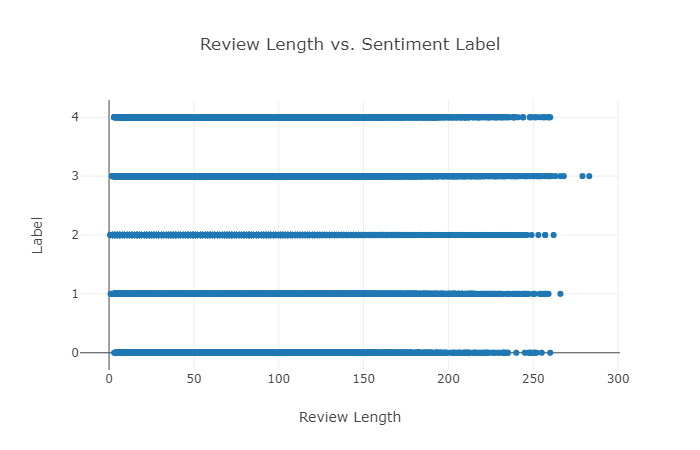

In [66]:
train['senLen'] = train['Phrase'].apply(lambda x: len(x))
data = train.sort_values(by='senLen')
plot = go.Scatter(x = data['senLen'], y = data['Sentiment'], mode='markers')
lyt = go.Layout(title="Review Length vs. Sentiment Label", xaxis=dict(title='Review Length'),yaxis=dict(title='Label'))
fig = go.Figure(data=[plot], layout=lyt)

py.iplot(fig)

No, there are no major correlations here.

Let's also visualize the wordclouds for sentences with sentiment = 0, sentiment = 1 and so on. 

### sentiment = 0

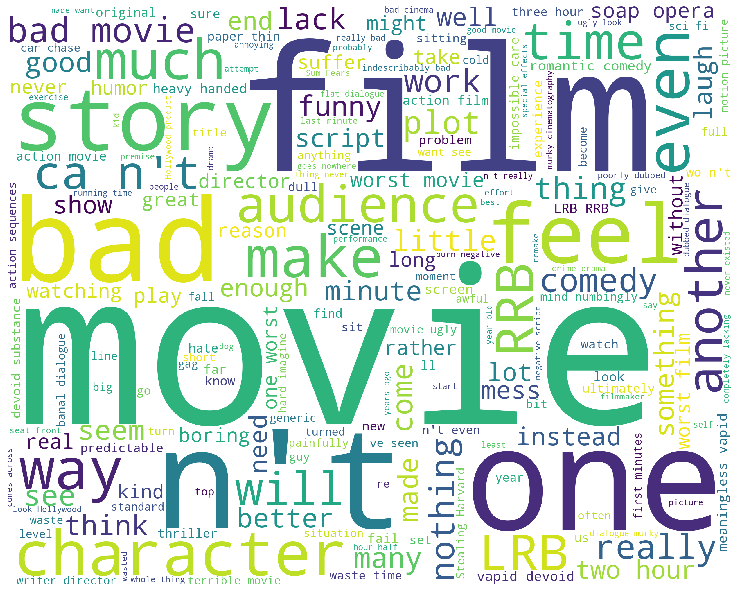

In [74]:
train_sen0 = train[ train['Sentiment'] == 0]
train_sen0 = train_sen0['Phrase']



wordcloud1 = WordCloud(stopwords=STOPWORDS, 
                       background_color='white',
                       width=2500,
                       height=2000).generate(" ".join(train_sen0))

plt.figure(1,figsize=(13, 13))

plt.imshow(wordcloud1)

plt.axis('off')

plt.show()

We can see that for sentiment = 0 there are such words as "movie", "film", "one", "bad", "feel", "excellent", "wonderful" and so on. 

### sentiment = 1

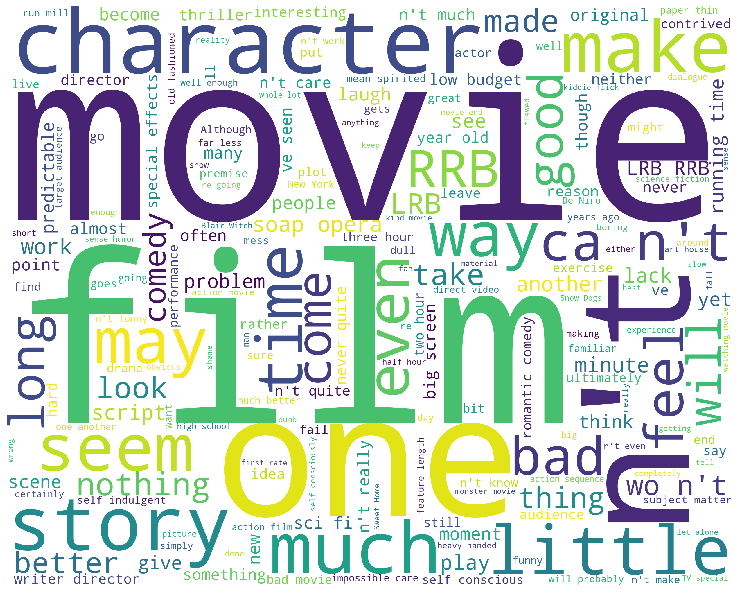

In [79]:
train_sen1 = train[ train['Sentiment'] == 1]
train_sen1 = train_sen1['Phrase']



wordcloud1 = WordCloud(stopwords=STOPWORDS, 
                       background_color='white',
                       width=2500,
                       height=2000).generate(" ".join(train_sen1))

plt.figure(1,figsize=(13, 13))

plt.imshow(wordcloud1)

plt.axis('off')

plt.show()

### sentiment = 2

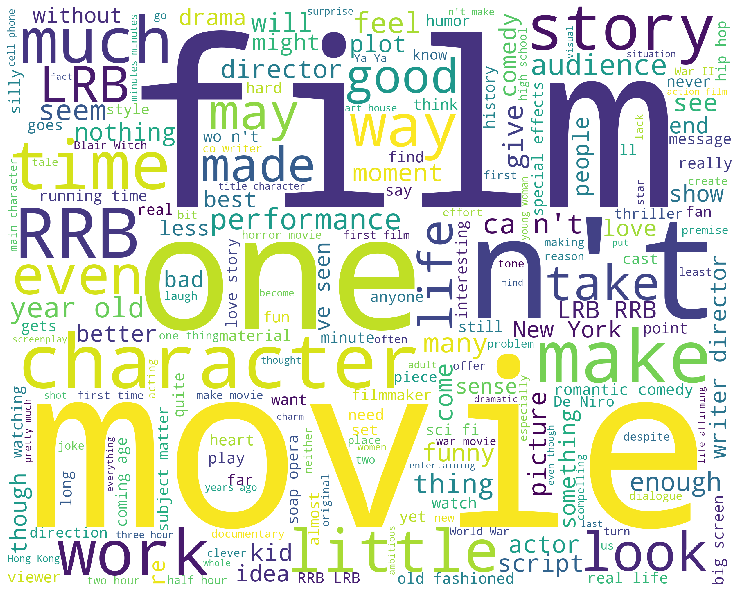

In [80]:
train_sen2 = train[ train['Sentiment'] == 2]
train_sen2 = train_sen2['Phrase']



wordcloud1 = WordCloud(stopwords=STOPWORDS, 
                       background_color='white',
                       width=2500,
                       height=2000).generate(" ".join(train_sen2))

plt.figure(1,figsize=(13, 13))

plt.imshow(wordcloud1)

plt.axis('off')

plt.show()

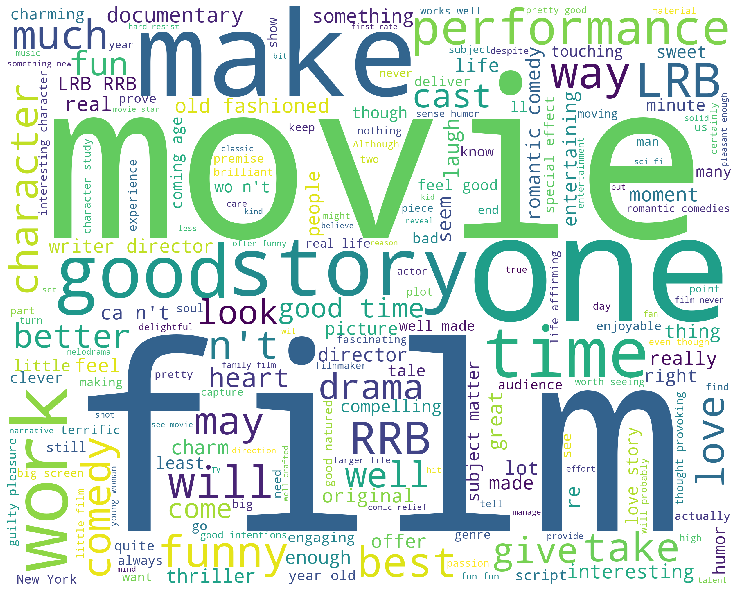

In [82]:
train_sen3 = train[ train['Sentiment'] == 3]
train_sen3 = train_sen3['Phrase']



wordcloud1 = WordCloud(stopwords=STOPWORDS, 
                       background_color='white',
                       width=2500,
                       height=2000).generate(" ".join(train_sen3))

plt.figure(1,figsize=(13, 13))

plt.imshow(wordcloud1)

plt.axis('off')

plt.show()

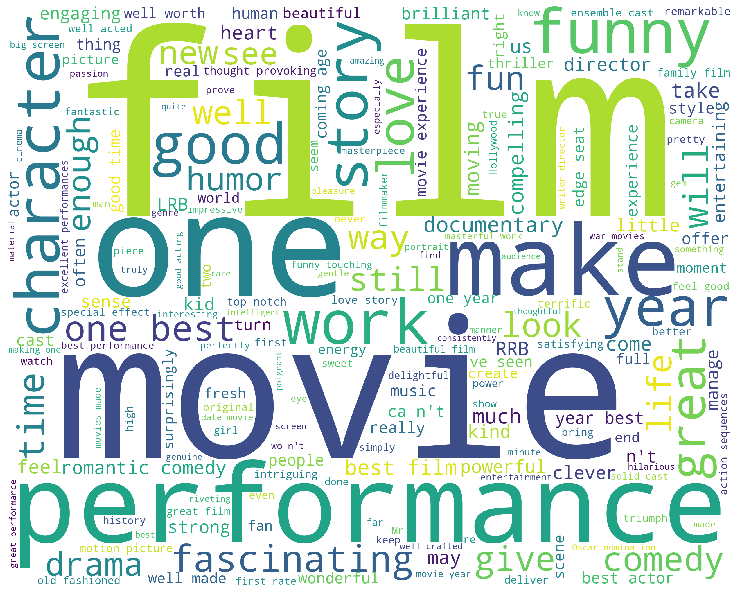

In [84]:
train_sen4 = train[ train['Sentiment'] == 4]
train_sen4 = train_sen4['Phrase']



wordcloud1 = WordCloud(stopwords=STOPWORDS, 
                       background_color='white',
                       width=2500,
                       height=2000).generate(" ".join(train_sen4))

plt.figure(1,figsize=(13, 13))

plt.imshow(wordcloud1)

plt.axis('off')

plt.show()

We can see that when the sentiment is bad, the most commun word not present in the good review are "bad", "lack" "bad movie", "little". Words quite tough.
Moreover, when the sentiment is godd, the most commun word looks like more nicely, like "performance", "good", "funny", "better" and so on. We could see a trend here, that's great.

<a id="4"></a> <br>
## Preprocessing the digit images

### Function for cleaning the reviews, tokenize and lemmatize them.
This function will take each phrase iteratively and it will :

- Use BeautifulSoup to remove html content
- Remove non-alphabetic characters
- Tokenize the sentences
- Lemmatize

In [94]:
def clean_sentences(df):
    reviews = []

    for sent in tqdm(df['Phrase']):
        
        #remove html content
        review_text = BeautifulSoup(sent).get_text()
        
        #remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
    
        #tokenize the sentences
        words = word_tokenize(review_text.lower())
    
        #lemmatize each word to its lemma
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
    
        reviews.append(lemma_words)

    return(reviews)

In [95]:
#cleaned reviews for both train and test set retrieved
train_sentences = clean_sentences(train)
test_sentences = clean_sentences(test)
print(len(train_sentences))
print(len(test_sentences))

100%|██████████████████████████████████████████████████████████████████████████| 66292/66292 [00:22<00:00, 2956.53it/s]

156060
66292


Let's also prepare our Y variable, the one we want to be well predicted as much as possible.

In [96]:
target=train.Sentiment.values
y_target=to_categorical(target) 
num_classes=y_target.shape[1]

In [97]:
X_train,X_val,y_train,y_val=train_test_split(train_sentences,y_target,test_size=0.2,stratify=y_target)

In [98]:
#It is needed for initializing tokenizer of keras and subsequent padding

unique_words = set()
len_max = 0

for sent in tqdm(X_train):
    
    unique_words.update(sent)
    
    if(len_max<len(sent)):
        len_max = len(sent)
        
#length of the list of unique_words gives the no of unique words
print(len(list(unique_words)))
print(len_max)

100%|██████████████████████████████████████████████████████████████████████| 124848/124848 [00:00<00:00, 736361.84it/s]

13734
48


In [99]:
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(X_train))

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(test_sentences)

#padding done to equalize the lengths of all input reviews. LSTM networks needs all inputs to be same length.
#Therefore reviews lesser than max length will be made equal using extra zeros at end. This is padding.

X_train = sequence.pad_sequences(X_train, maxlen=len_max)
X_val = sequence.pad_sequences(X_val, maxlen=len_max)
X_test = sequence.pad_sequences(X_test, maxlen=len_max)

print(X_train.shape,X_val.shape,X_test.shape)

(124848, 48) (31212, 48) (66292, 48)


<a id="5"></a> <br>
## Deep Learning (Neural Network Architecture)

I used the Keras Sequential API, where you have just to add one layer at a time. 

In [59]:
model=Sequential()
model.add(Embedding(len(list(unique_words)),300,input_length=len_max))
model.add(LSTM(128,dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.005),metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 48, 300)           4120200   
_________________________________________________________________
lstm_5 (LSTM)                (None, 48, 128)           219648    
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_9 (Dense)              (None, 100)               6500      
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 505       
Total params: 4,396,261
Trainable params: 4,396,261
Non-trainable params: 0
____________________________________________

In order to make our optimizer converge faster and closest to the global minimum of our loss function (categorical_crossentropy), I will use an converging method of the learning rate.
The learning rate is the step by which the optimizer walks through the 'loss landscape'. The higher the learning rate is, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with an high learning rate and the optimizer could probably fall into a local minima, which is not especially good. We prefer fall into a global minimum, it's more efficiency !
Its better to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function.
To keep the advantage of the fast computation time with a high learning rate, we will decrease the learning rate dynamically every X steps (epochs) but only when the accuracy is not enhanced !
With the ReduceLROnPlateau function from Keras.callbacks, I choose to reduce the learning rate by half if the accuracy is not improved after 3 epochs. 

I already used these parameters in another Kaggle project and those had well performed so let's see if they could do it again.

It's all good ! Let's train our model and see how well is performing !

In [61]:
history = model.fit(X_train, y_train, batch_size = 256, epochs = 6, 
         validation_data = (X_val, y_val), verbose = 2, callbacks=[learning_rate_reduction])

Train on 124848 samples, validate on 31212 samples
Epoch 1/6
124848/124848 - 242s - loss: 1.0214 - accuracy: 0.5898 - val_loss: 0.8606 - val_accuracy: 0.6474
Epoch 2/6
124848/124848 - 250s - loss: 0.8221 - accuracy: 0.6634 - val_loss: 0.8223 - val_accuracy: 0.6542
Epoch 3/6
124848/124848 - 256s - loss: 0.7571 - accuracy: 0.6883 - val_loss: 0.8112 - val_accuracy: 0.6708
Epoch 4/6
124848/124848 - 284s - loss: 0.7177 - accuracy: 0.7015 - val_loss: 0.8164 - val_accuracy: 0.6715
Epoch 5/6
124848/124848 - 361s - loss: 0.6936 - accuracy: 0.7110 - val_loss: 0.8330 - val_accuracy: 0.6685
Epoch 6/6
124848/124848 - 319s - loss: 0.6766 - accuracy: 0.7167 - val_loss: 0.8395 - val_accuracy: 0.6713


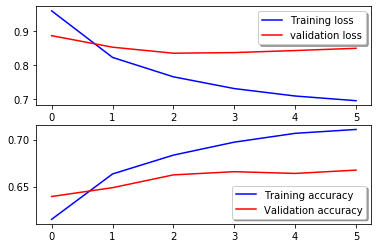

In [22]:
import matplotlib.pyplot as plt

# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

This model seems to overfit. That's the problem with some Deep Learning model, they tend to overfit sometimes. Maybe with BatchNormalization the model will generalize well ?

<a id="6"></a> <br>
## First submission to Kaggle

In [62]:
y_pred=model.predict_classes(X_test)

sub_file = pd.read_csv('sampleSubmission.csv',sep=',')
sub_file.Sentiment=y_pred
sub_file.to_csv('SubmissionDeepLearning.csv',index=False)

We obtained 0,64964 kaggle submission accuracy, we are 120 on 860. Let's see if we can optimize this.

Let's try the same neural network but this time with BatchNormalization. 

In [53]:
model=Sequential()
model.add(Embedding(len(list(unique_words)),300,input_length=len_max))
model.add(LSTM(128,dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(100,activation='relu'))
model.add(BatchNormalization(axis = 1)),
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.005),metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 48, 300)           4120200   
_________________________________________________________________
lstm_4 (LSTM)                (None, 48, 128)           219648    
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               6500      
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                

In [54]:
history = model.fit(X_train, y_train, batch_size = 256, epochs = 6, 
         validation_data = (X_val, y_val), verbose = 2, callbacks=[learning_rate_reduction])

Train on 124848 samples, validate on 31212 samples
Epoch 1/6
124848/124848 - 207s - loss: 1.0585 - accuracy: 0.5763 - val_loss: 0.8879 - val_accuracy: 0.6369
Epoch 2/6
124848/124848 - 214s - loss: 0.8476 - accuracy: 0.6522 - val_loss: 0.8283 - val_accuracy: 0.6585
Epoch 3/6
124848/124848 - 215s - loss: 0.7806 - accuracy: 0.6770 - val_loss: 0.8216 - val_accuracy: 0.6630
Epoch 4/6
124848/124848 - 215s - loss: 0.7362 - accuracy: 0.6944 - val_loss: 0.8135 - val_accuracy: 0.6723
Epoch 5/6
124848/124848 - 216s - loss: 0.7063 - accuracy: 0.7082 - val_loss: 0.8298 - val_accuracy: 0.6682
Epoch 6/6
124848/124848 - 218s - loss: 0.6857 - accuracy: 0.7154 - val_loss: 0.8294 - val_accuracy: 0.6716


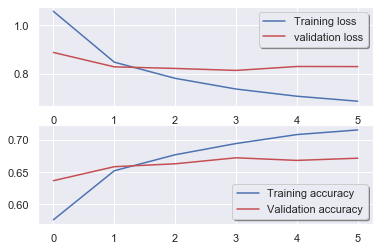

In [55]:
import matplotlib.pyplot as plt

# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [56]:
y_pred=model.predict_classes(X_test)

sub_file = pd.read_csv('sampleSubmission.csv',sep=',')
sub_file.Sentiment=y_pred
sub_file.to_csv('SubmissionDeepLearning2.csv',index=False)

We obtained 0.64621 on Kaggle. That's slightly worse. Too bad, I thought BatchNormalization could improve my model's accuracy. I was wrong. 

Let's see if more common Machine Learning models could be improve our performances.Note that it has been found that recurring neural networks (RNN's), like the ones we have build earlier,  achieve higher accuracy at such tasks. But that's doesn't mean we cannot try others methods such as classic Machine Learning Models.

<a id="7"></a> <br>
## Machine Learning

For now, let's just import all of our machine learning models :

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import sklearn.model_selection as ms
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import StratifiedKFold

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import MultinomialNB

from sklearn import tree
from sklearn import metrics
from sklearn import ensemble
from sklearn import linear_model 
from sklearn import naive_bayes 

<a id="8"></a> <br>
## Data Preprocessing

Let's repeat our preprocessing, but with slightly improvement. To have data usable for machine learning packages. In fact, we just add TfidfVectorizer at the end. In the Deep Learning part, we haven't use it because it wasn't necessary, we have used others methods. It's because Deep Learning models packages doesn't need the exact same data to be fit within than Machine Learning models. 

Let's do this.

In [85]:
y=train.Sentiment

In [86]:
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.snowball import EnglishStemmer
stemmer = EnglishStemmer() 

stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()



def clean_text(text):
    text = re.sub(r'[^"[a-z][a-z][^\w\s\d+"]{2,}"]','',text, re.UNICODE)
    text = text.lower()
    text = [lemmatizer.lemmatize(token, pos='v') for token in text.split(" ")]
    text = [word for word in text if not word in stop_words]
    text = [stemmer.stem(word) for word in text]             
    text = " ".join(text)
    return text

train['Processed_Phrase'] = train.Phrase.apply(lambda x: clean_text(x))

In [27]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,Processed_Phrase
0,1,1,A series of escapades demonstrating the adage ...,1,seri escapad demonstr adag good goos also good...
1,2,1,A series of escapades demonstrating the adage ...,2,seri escapad demonstr adag good goos
2,3,1,A series,2,seri
3,4,1,A,2,
4,5,1,series,2,seri


In [87]:
X = train['Processed_Phrase']

In [88]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(analyzer = 'word', token_pattern = "[a-z][a-z']{2,}", stop_words = stop_words, max_df = 0.8)
X = tfidf_vectorizer.fit_transform(train['Processed_Phrase'])

<a id="9"></a> <br>
## Model selection

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=1)

def score_model(model):
    model.fit(X_train, y_train)
    y_pred_class = model.predict(X_test)
    return metrics.accuracy_score(y_test, y_pred_class)

In [123]:
scores = {}

scores['tree'] = score_model(tree.DecisionTreeClassifier())

scores['extra_tree'] = score_model(ensemble.ExtraTreesClassifier())

scores['forest'] = score_model(ensemble.RandomForestClassifier())

scores['ada_boost'] = score_model(ensemble.AdaBoostClassifier())

scores['bagging'] = score_model(ensemble.BaggingClassifier())

scores['grad_boost'] = score_model(ensemble.GradientBoostingClassifier())

scores['ridge'] = score_model(linear_model.RidgeClassifier())

scores['passive'] = score_model(linear_model.PassiveAggressiveClassifier())

scores['sgd'] = score_model(linear_model.SGDClassifier())

scores['xgboost'] = score_model(xgb.XGBClassifier())

scores['LightGBM'] = score_model(LGBMClassifier())

scores['LinearSVC'] = score_model(LinearSVC())

scores['LR'] = score_model(LogisticRegression())

In [124]:
scores

{'tree': 0.6266179674484172,
 'extra_tree': 0.6403306420607459,
 'forest': 0.6433423042419583,
 'ada_boost': 0.5487632961681405,
 'bagging': 0.632481097013969,
 'grad_boost': 0.5408496732026143,
 'ridge': 0.6233499935922081,
 'passive': 0.6032936050237089,
 'sgd': 0.5617070357554786,
 'xgboost': 0.5277136998590286,
 'LightGBM': 0.5872100474176599,
 'LinearSVC': 0.6292772010765091,
 'LR': 0.6251441753171857}

Random Forest seems to be the one who perform better

<a id="10"></a> <br>
## Second submission to Kaggle

In [30]:
test['Processed_Phrase'] = test.Phrase.apply(lambda x: clean_text(x))

X_test = tfidf_vectorizer.transform(test['Processed_Phrase'])

In [31]:
rfc = RandomForestClassifier()
rfc.fit(X, y)
y_pred_class = rfc.predict(X_test)

In [34]:
final_pred = pd.read_csv('sampleSubmission.csv', sep=',')
final_pred.Sentiment=y_pred_class
final_pred.to_csv('SubmissionMachineLearning.csv', sep=',', index=False)

This time, we obtained 0.60339. That's worse than our previous result, as expected. The RNN's are far more suited for NLP indeed. We have tried at least. That's not so bad.

<a id="11"></a> <br>
## Deep Learning (part 2) 

I wanted to see if a more in depth model could do better than our classic LSTM Neural Network. At least try and practice more complex Neural Network architecture. For this part, I took my inspiration from this kernel :

https://www.kaggle.com/artgor/movie-review-sentiment-analysis-eda-and-models#Deep-learning

I followed his architecture with my pre processing steps to enhance my skill in Deep Learning. I will build several Deep Learning models and blend them. Blend models is sometimes a great idea, because if a model fail to predict one kind of sentences, maybe another model will be good at it. So we take the best within our models result and gather them. 
The downside part is it take much more longer if you train on huge Deep Learning structure, so I would recommend to use it only for Kaggle project or if you company have huge computer or/and she give you a large amount of time to process your project.

Let's import some packages again.

In [157]:
from tensorflow.python.keras.layers import LSTM, CuDNNLSTM, CuDNNGRU
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, GRU, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten
from tensorflow.keras.models import Model, load_model

Just a little much of pre processing necessary for these models.

In [158]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words + 1, embed_size))

embed_size = 300
max_features = 30000

Let's build the fonction build_model1 present in the kernel :

In [163]:

def build_model1(lr=0.0, lr_d=0.0, units=0, spatial_dr=0.0, kernel_size1=3, kernel_size2=2, dense_units=128, dr=0.1, conv_size=32):
    file_path = "best_model.hdf5"
    check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
                                  save_best_only = True, mode = "min")
    early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 3)
    
    inp = Input(shape = (len_max,))
    x = Embedding(13735, embed_size, weights = [embedding_matrix], trainable = False)(inp)
    x1 = SpatialDropout1D(spatial_dr)(x)

    x_gru = Bidirectional(GRU(units, return_sequences = True))(x1)
    x1 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool1_gru = GlobalAveragePooling1D()(x1)
    max_pool1_gru = GlobalMaxPooling1D()(x1)
    
    x3 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool3_gru = GlobalAveragePooling1D()(x3)
    max_pool3_gru = GlobalMaxPooling1D()(x3)
    
    x_lstm = Bidirectional(LSTM(units, return_sequences = True))(x1)
    x1 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    avg_pool1_lstm = GlobalAveragePooling1D()(x1)
    max_pool1_lstm = GlobalMaxPooling1D()(x1)
    
    x3 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    avg_pool3_lstm = GlobalAveragePooling1D()(x3)
    max_pool3_lstm = GlobalMaxPooling1D()(x3)
    
    
    x = concatenate([avg_pool1_gru, max_pool1_gru, avg_pool3_gru, max_pool3_gru,
                    avg_pool1_lstm, max_pool1_lstm, avg_pool3_lstm, max_pool3_lstm])
    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(dense_units, activation='relu') (x))
    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(int(dense_units / 2), activation='relu') (x))
    x = Dense(5, activation = "sigmoid")(x)
    model = Model(inputs = inp, outputs = x)
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])
    history = model.fit(X_train, y_train, batch_size = 128, epochs = 20, validation_split=0.1, 
                        verbose = 1, callbacks = [check_point, early_stop])
    model = load_model(file_path)
    return model

And with this function, let's create model 1 and model 2 :

In [164]:
model1 = build_model1(lr = 1e-3, lr_d = 1e-10, units = 64, spatial_dr = 0.3, kernel_size1=3, kernel_size2=2, dense_units=32, dr=0.1, conv_size=32)

Train on 112363 samples, validate on 12485 samples
Epoch 1/20
112256/112363 [============================>.] - ETA: 0s - loss: 0.5932 - accuracy: 0.8040
Epoch 00001: val_loss improved from inf to 0.52028, saving model to best_model.hdf5
112363/112363 [==============================] - 271s 2ms/sample - loss: 0.5932 - accuracy: 0.8040 - val_loss: 0.5203 - val_accuracy: 0.8035
Epoch 2/20
112256/112363 [============================>.] - ETA: 0s - loss: 0.4825 - accuracy: 0.8041
Epoch 00002: val_loss improved from 0.52028 to 0.45594, saving model to best_model.hdf5
112363/112363 [==============================] - 274s 2ms/sample - loss: 0.4825 - accuracy: 0.8040 - val_loss: 0.4559 - val_accuracy: 0.8035
Epoch 3/20
112256/112363 [============================>.] - ETA: 0s - loss: 0.4416 - accuracy: 0.8041
Epoch 00003: val_loss improved from 0.45594 to 0.43186, saving model to best_model.hdf5
112363/112363 [==============================] - 281s 3ms/sample - loss: 0.4416 - accuracy: 0.8040 - 

In [169]:
model2 = build_model1(lr = 1e-3, lr_d = 1e-10, units = 128, spatial_dr = 0.5, kernel_size1=3, kernel_size2=2, dense_units=64, dr=0.2, conv_size=32)

Train on 112363 samples, validate on 12485 samples
Epoch 1/20
112256/112363 [============================>.] - ETA: 1s - loss: 0.5932 - accuracy: 0.8040
Epoch 00001: val_loss improved from inf to 0.52026, saving model to best_model.hdf5
112363/112363 [==============================] - 1239s 11ms/sample - loss: 0.5931 - accuracy: 0.8040 - val_loss: 0.5203 - val_accuracy: 0.8035
Epoch 2/20
112256/112363 [============================>.] - ETA: 1s - loss: 0.4826 - accuracy: 0.8040
Epoch 00002: val_loss improved from 0.52026 to 0.45593, saving model to best_model.hdf5
112363/112363 [==============================] - 1316s 12ms/sample - loss: 0.4825 - accuracy: 0.8040 - val_loss: 0.4559 - val_accuracy: 0.8035
Epoch 3/20
112256/112363 [============================>.] - ETA: 1s - loss: 0.4416 - accuracy: 0.8040
Epoch 00003: val_loss improved from 0.45593 to 0.43186, saving model to best_model.hdf5
112363/112363 [==============================] - 1325s 12ms/sample - loss: 0.4416 - accuracy: 0.8

Let's create another function build_model2 and build our last 3 models :

In [180]:
def build_model2(lr=0.0, lr_d=0.0, units=0, spatial_dr=0.0, kernel_size1=3, kernel_size2=2, dense_units=128, dr=0.1, conv_size=32):
    file_path = "best_model.hdf5"
    check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
                                  save_best_only = True, mode = "min")
    early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 3)

    inp = Input(shape = (len_max,))
    x = Embedding(13735, embed_size, weights = [embedding_matrix], trainable = False)(inp)
    x1 = SpatialDropout1D(spatial_dr)(x)

    x_gru = Bidirectional(GRU(units, return_sequences = True))(x1)
    x_lstm = Bidirectional(LSTM(units, return_sequences = True))(x1)
    
    x_conv1 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool1_gru = GlobalAveragePooling1D()(x_conv1)
    max_pool1_gru = GlobalMaxPooling1D()(x_conv1)
    
    x_conv2 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool2_gru = GlobalAveragePooling1D()(x_conv2)
    max_pool2_gru = GlobalMaxPooling1D()(x_conv2)
    
    
    x_conv3 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    avg_pool1_lstm = GlobalAveragePooling1D()(x_conv3)
    max_pool1_lstm = GlobalMaxPooling1D()(x_conv3)
    
    x_conv4 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    avg_pool2_lstm = GlobalAveragePooling1D()(x_conv4)
    max_pool2_lstm = GlobalMaxPooling1D()(x_conv4)
    
    
    x = concatenate([avg_pool1_gru, max_pool1_gru, avg_pool2_gru, max_pool2_gru,
                    avg_pool1_lstm, max_pool1_lstm, avg_pool2_lstm, max_pool2_lstm])
    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(dense_units, activation='relu') (x))
    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(int(dense_units / 2), activation='relu') (x))
    x = Dense(5, activation = "sigmoid")(x)
    model = Model(inputs = inp, outputs = x)
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])
    history = model.fit(X_train, y_train, batch_size = 128, epochs = 20, validation_split=0.1, 
                        verbose = 1, callbacks = [check_point, early_stop])
    model = load_model(file_path)
    return model

In [181]:
model3 = build_model2(lr = 1e-4, lr_d = 0, units = 64, spatial_dr = 0.5, kernel_size1=4, kernel_size2=3, dense_units=32, dr=0.1, conv_size=32)

Train on 112363 samples, validate on 12485 samples
Epoch 1/20
112256/112363 [============================>.] - ETA: 0s - loss: 0.6803 - accuracy: 0.8040
Epoch 00001: val_loss improved from inf to 0.66781, saving model to best_model.hdf5
112363/112363 [==============================] - 929s 8ms/sample - loss: 0.6803 - accuracy: 0.8040 - val_loss: 0.6678 - val_accuracy: 0.8035
Epoch 2/20
112256/112363 [============================>.] - ETA: 0s - loss: 0.6560 - accuracy: 0.8040
Epoch 00002: val_loss improved from 0.66781 to 0.64448, saving model to best_model.hdf5
112363/112363 [==============================] - 1024s 9ms/sample - loss: 0.6560 - accuracy: 0.8040 - val_loss: 0.6445 - val_accuracy: 0.8035
Epoch 3/20
112256/112363 [============================>.] - ETA: 0s - loss: 0.6335 - accuracy: 0.8040
Epoch 00003: val_loss improved from 0.64448 to 0.62290, saving model to best_model.hdf5
112363/112363 [==============================] - 1043s 9ms/sample - loss: 0.6335 - accuracy: 0.8040 

In [182]:
model4 = build_model2(lr = 1e-3, lr_d = 0, units = 64, spatial_dr = 0.5, kernel_size1=3, kernel_size2=3, dense_units=64, dr=0.3, conv_size=32)

Train on 112363 samples, validate on 12485 samples
Epoch 1/20
112256/112363 [============================>.] - ETA: 1s - loss: 0.5932 - accuracy: 0.8040
Epoch 00001: val_loss improved from inf to 0.52026, saving model to best_model.hdf5
112363/112363 [==============================] - 1100s 10ms/sample - loss: 0.5931 - accuracy: 0.8040 - val_loss: 0.5203 - val_accuracy: 0.8035
Epoch 2/20
112256/112363 [============================>.] - ETA: 1s - loss: 0.4825 - accuracy: 0.8040
Epoch 00002: val_loss improved from 0.52026 to 0.45594, saving model to best_model.hdf5
112363/112363 [==============================] - 1099s 10ms/sample - loss: 0.4825 - accuracy: 0.8040 - val_loss: 0.4559 - val_accuracy: 0.8035
Epoch 3/20
112256/112363 [============================>.] - ETA: 1s - loss: 0.4416 - accuracy: 0.8040
Epoch 00003: val_loss improved from 0.45594 to 0.43187, saving model to best_model.hdf5
112363/112363 [==============================] - 1099s 10ms/sample - loss: 0.4416 - accuracy: 0.8

In [183]:
model5 = build_model2(lr = 1e-3, lr_d = 1e-7, units = 64, spatial_dr = 0.3, kernel_size1=3, kernel_size2=3, dense_units=64, dr=0.4, conv_size=64)

Train on 112363 samples, validate on 12485 samples
Epoch 1/20
112256/112363 [============================>.] - ETA: 1s - loss: 0.5932 - accuracy: 0.8040
Epoch 00001: val_loss improved from inf to 0.52025, saving model to best_model.hdf5
112363/112363 [==============================] - 1329s 12ms/sample - loss: 0.5931 - accuracy: 0.8040 - val_loss: 0.5202 - val_accuracy: 0.8035
Epoch 2/20
112256/112363 [============================>.] - ETA: 1s - loss: 0.4825 - accuracy: 0.8041
Epoch 00002: val_loss improved from 0.52025 to 0.45594, saving model to best_model.hdf5
112363/112363 [==============================] - 1334s 12ms/sample - loss: 0.4825 - accuracy: 0.8040 - val_loss: 0.4559 - val_accuracy: 0.8035
Epoch 3/20
112256/112363 [============================>.] - ETA: 1s - loss: 0.4416 - accuracy: 0.8040
Epoch 00003: val_loss improved from 0.45594 to 0.43187, saving model to best_model.hdf5
112363/112363 [==============================] - 1336s 12ms/sample - loss: 0.4416 - accuracy: 0.8

<a id="12"></a> <br>
## Third submission to Kaggle 

Let's combine all of our predictions and take the best bet.

In [184]:
pred1 = model1.predict(X_test, batch_size = 1024)
pred = pred1
pred2 = model2.predict(X_test, batch_size = 1024)
pred += pred2
pred3 = model3.predict(X_test, batch_size = 1024)
pred += pred3
pred4 = model4.predict(X_test, batch_size = 1024)
pred += pred4
pred5 = model5.predict(X_test, batch_size = 1024)
pred += pred5

In [186]:
predictions = np.round(np.argmax(pred, axis=1)).astype(int)
sub_file['Sentiment'] = predictions
sub_file.to_csv("blendingDL.csv", index=False)

Again, this kind of methods take forever so I wouldn't recommend to use it for real case in real job. Moreover given the result obtained (I obtained 0.61159), in this case, it's not worth it. I mostly made this to train myself. I think, in real case, the classic RNN, LSTM Neural Network are more efficient since it's much faster and less complex to implement. But if you want to obtained immaculate results and you have as much time as you need, then blending/ensembling could be a great idea.